In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
train = pd.read_csv('train.csv', parse_dates=['date'])
stores = pd.read_csv('stores.csv')
oil = pd.read_csv('oil.csv', parse_dates=['date'])
holidays = pd.read_csv('holidays_events.csv', parse_dates=['date'])

In [24]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [25]:
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate(method='linear')

In [26]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [27]:
train['date'] = pd.to_datetime(train['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays['date'] = pd.to_datetime(holidays['date'])

In [28]:
train = train.merge(stores, on='store_nbr', how='left')
train = train.merge(oil, on='date', how='left')
train = train.merge(holidays, on='date', how='left')

#Feature Engineering

In [29]:
train['day'] = train['date'].dt.day
train['week'] = train['date'].dt.isocalendar().week
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['day_of_week'] = train['date'].dt.dayofweek

#Event based Features

In [30]:
train['is_holiday'] = train["type_x"].notna().astype(int)
train['is_weekend'] = (train['day_of_week']>=5).astype(int)
train['is_gov_payday'] = train['day'].isin([15, train['date'].dt.days_in_month]).astype(int)
train['earthquake_impact'] = (train['date'] == '2016-04-16').astype(int)


#Rolling statistics

In [31]:
train['sales_lag_7'] = train.groupby(['store_nbr' , 'family'])['sales'].shift(7)
train['sales_lag_30'] = train.groupby(['store_nbr' , 'family'])['sales'].shift(30)
train['rolling_mean_7'] = train.groupby(['store_nbr' , 'family'])['sales'].rolling(7).mean().reset_index(level=[0,1], drop=True)
train['rolling_mean_7'] = train.groupby(['store_nbr' , 'family'])['sales'].rolling(7).std().reset_index(level=[0,1], drop=True)


#identify top-selling product families per cluster

In [32]:
store_avg_sales = train.groupby('store_nbr')['sales'].mean().rename('avg_store_sales')
train = train.merge(store_avg_sales, on='store_nbr' , how='left')

#exploratory data analysis(EDA)

Exploratory Data Analysis


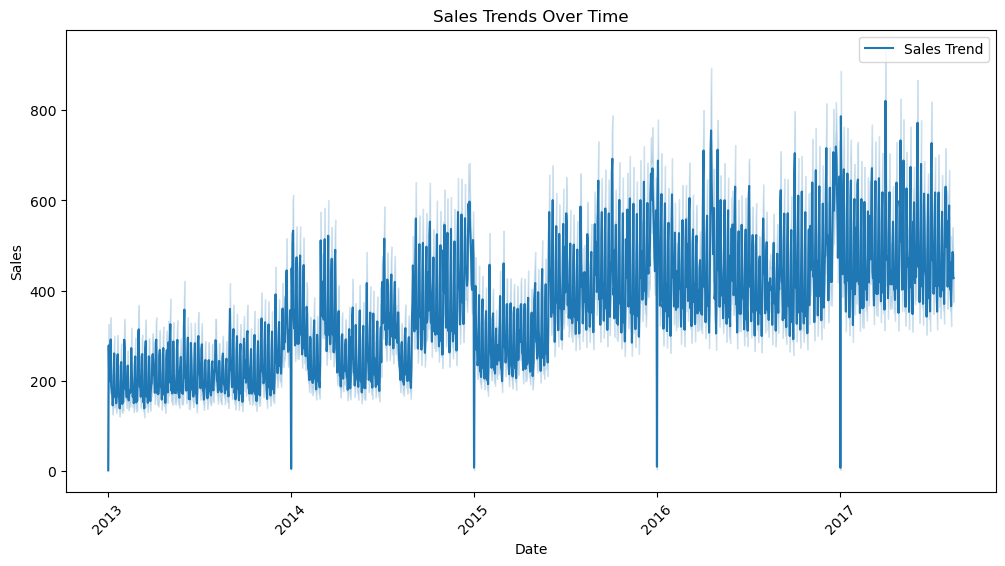

In [34]:
print("Exploratory Data Analysis")
plt.figure(figsize=(12,6))
sns.lineplot(x='date', y='sales', data=train, label='Sales Trend')
plt.title('Sales Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.legend()
plt.show()

#Anlyze sales before and after holidays and promotions

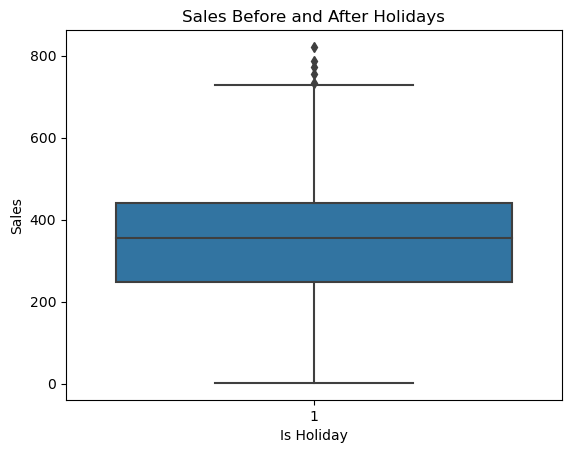

In [35]:
holiday_sales = train.groupby(['date', 'is_holiday'])['sales'].mean().reset_index()
sns.boxplot(x='is_holiday', y='sales', data=holiday_sales)
plt.title('Sales Before and After Holidays')
plt.xlabel('Is Holiday')
plt.ylabel('Sales')
plt.show()

#correlation between oil prices and sales trends

Correlation between Sales and Oil Prices:
               sales  dcoilwtico
sales       1.000000   -0.079009
dcoilwtico -0.079009    1.000000


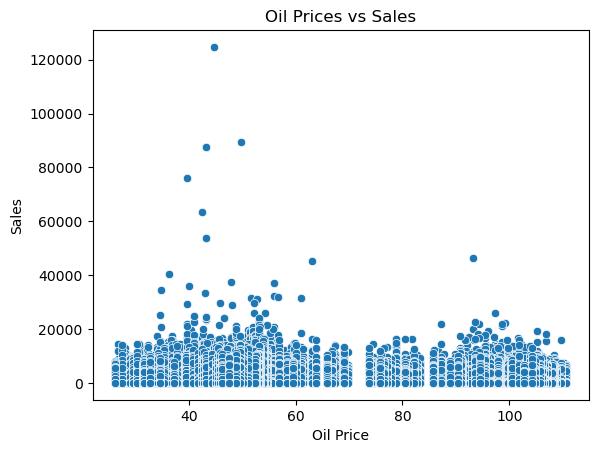

In [37]:
correlation = train[['sales', 'dcoilwtico']].corr()
print('Correlation between Sales and Oil Prices:')
print(correlation)
sns.scatterplot(x='dcoilwtico', y='sales', data=train)
plt.title('Oil Prices vs Sales')
plt.xlabel('Oil Price')
plt.ylabel('Sales')
plt.show()

#Anamolies in data

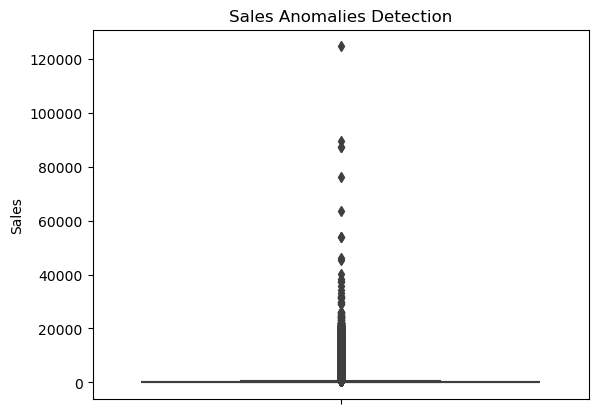

Data Processing and feature engineering completed.


In [38]:
sns.boxplot(y='sales', data=train)
plt.title('Sales Anomalies Detection')
plt.ylabel('Sales')
plt.show()
train.to_csv('processed_train.csv', index=False)
print("Data Processing and feature engineering completed.")

#Model Selection-Naivebayes

In [41]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,...,day_of_week,is_holiday,is_weekend,is_gov_payday,earthquake_impact,sales_lag_7,sales_lag_30,rolling_mean_7,avg_store_sales,naive_forecast
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,1,1,0,0,0,NaN,NaN,NaN,254.651925,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,1,1,0,0,0,NaN,NaN,NaN,254.651925,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,1,1,0,0,0,NaN,NaN,NaN,254.651925,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,1,1,0,0,0,NaN,NaN,NaN,254.651925,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,1,1,0,0,0,NaN,NaN,NaN,254.651925,NaN


In [40]:
train['naive_forecast'] = train.groupby(['store_nbr', 'family'])['sales'].shift(1)

In [43]:
features = ['day', 'week', 'month', 'day_of_week', 'is_holiday', 'is_weekend', 'is_gov_payday', 'earthquake_impact', 'sales_lag_7', 'sales_lag_30', 'rolling_mean_7', 'avg_store_sales']
X = train[features].dropna()
y= train.loc[X.index, 'sales']

In [46]:
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

#ARIMA 

In [48]:
!pip install statsmodels
from statsmodels.tsa.arima.model import ARIMA

In [50]:
arima_model = ARIMA(y_train, order=(2,1,0))
arima_model_fit = arima_model.fit(low_memory=True)
arima_preds = arima_model_fit.forecast(steps=len(y_val))

C:\downloaded programs\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\downloaded programs\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\downloaded programs\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\downloaded programs\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\downloaded programs\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling

#Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_val)
smaple_size = 10000
X_sample = X_train.sample(sample_size, random_state=42)
y_sample = y_train.loc[X_sample.index]
rf_model.fit(X_sample, y_sample)

#XGBoost

In [ ]:
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100. learning_rate=0.1)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)

#Model Evaluation

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    rmse = nn.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'{model_name}) - RMSE:{rmse:.2f}, MAPE: {mape:.2f}, R2: {r2:.2f}")
          
print("Model Evaluation:")                              
if 'arima_preds' in locals():
  evaluate_model(y_val, arima_preds, "ARIMA")       
else:
  print("ARIMA predictions not found.")        
if "rf_model" in locals():
  rf_preds = rf_model.predict(X_val)
else:          
  print("Random forst model not trained.")   
          
evaluate_model(y_val, arima_preds, "ARIMA")          
evaluate_model(y_val, ref_preds, "RandomForest")          
evaluate_model(y_val, xgb_preds, "XGBoost")          

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(x=y_val.index, y=y_val, label='Actual Sales')
sns.lineplot(x=y_val.index, y=rf_preds, label='Random Forest Predictions')
sns.lineplot(x=y_val.index, y-xgb_preds, label+'XGBoost Predictions')
plt.legend()
plt.title('Actual vs Predicted Sales')
plt.show()

Print("Model training, forecasting, and evaluation completed.")